In [1]:
# importing libraries and functions
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# Processing manoeuvre and orbital data 

In [3]:
# Helper function for Date conversion
def doy_to_datetime(year: int, doy: int, hour: int, minute: int, second: float=0.0):
    return datetime(year, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)

In [4]:
# Processing manoeuvre file h2aman.txt
def parse_non_fengyun_line(line):
    parts = line.split()
    if len(parts) < 9:
        return None
    try:
        return {
            'satellite': parts[0],
            'start_time': doy_to_datetime(int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4])),
            'end_time': doy_to_datetime(int(parts[5]), int(parts[6]), int(parts[7]), int(parts[8]))
        }
    except Exception as e:
        print(f"Skipping line due to error: {e}")
        return None

def process_manoeuvre_file(path):
    with open(path) as f:
        data = [parse_non_fengyun_line(line.strip()) for line in f if line.strip()]
    return pd.DataFrame([d for d in data if d])


In [5]:
# Processing orbital elements from Haiyang-2A.csv file

def load_orbital_elements(filepath: str):
    try:
        df = pd.read_csv(filepath, index_col=0, parse_dates=True)
        df.sort_index(inplace=True)
        df.index.name = 'timestamp' # naming the unnamed column as 'timestamp'
        return df
    except Exception as e:
        print(f"Error loading orbital elements file: {filepath}\n{e}")
        return pd.DataFrame()   


In [6]:
# Loading both files
def main():
    base_dir = '../satellite_data'
    manoeuvre_file = os.path.join(base_dir, 'manoeuvres', 'h2aman.txt')
    orbital_file = os.path.join(base_dir, 'orbital_elements','Haiyang-2A.csv')

    print(f"\nProcessing manoeuvre file: {manoeuvre_file}")
    man_df = process_manoeuvre_file(manoeuvre_file)
    print(man_df.head())

    print(f"\nProcessing orbital elements file: {orbital_file}")
    orb_df = load_orbital_elements(orbital_file)
    print(orb_df.head())

    return man_df, orb_df

In [7]:
man_df, orb_df = main()


Processing manoeuvre file: ../satellite_data/manoeuvres/h2aman.txt
  satellite          start_time            end_time
0     HY-2A 2011-09-28 16:20:00 2011-09-28 16:20:00
1     HY-2A 2012-02-14 03:05:00 2012-02-14 03:05:00
2     HY-2A 2012-02-24 03:20:00 2012-02-24 03:20:00
3     HY-2A 2012-04-20 03:20:00 2012-04-20 03:20:00
4     HY-2A 2012-06-08 02:35:00 2012-06-08 02:35:00

Processing orbital elements file: ../satellite_data/orbital_elements/Haiyang-2A.csv
                            eccentricity  argument of perigee  inclination  \
timestamp                                                                    
2011-10-08 03:08:31.065504      0.000158             1.456236     1.734299   
2011-10-09 01:46:27.454367      0.000158             1.412851     1.734299   
2011-10-10 03:53:18.699936      0.000149             1.414537     1.734285   
2011-10-11 02:31:15.109536      0.000147             1.360987     1.734292   
2011-10-12 02:53:38.975135      0.000150             1.457867     1

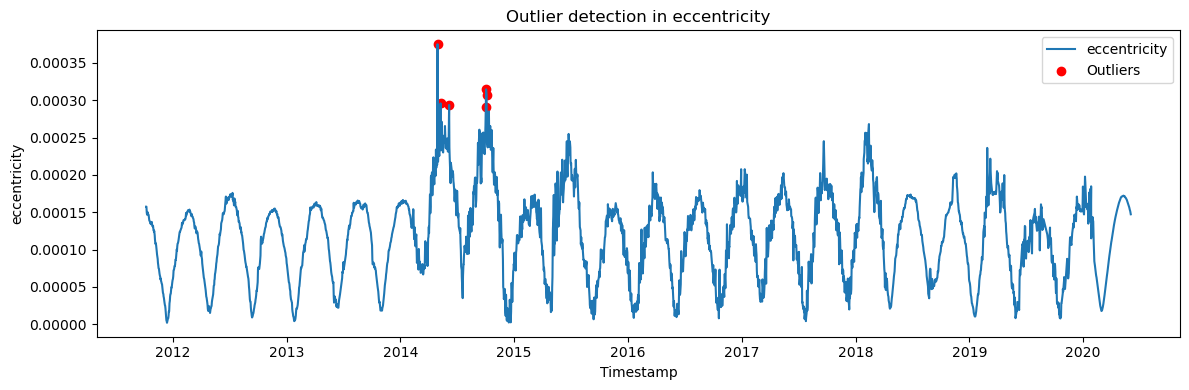

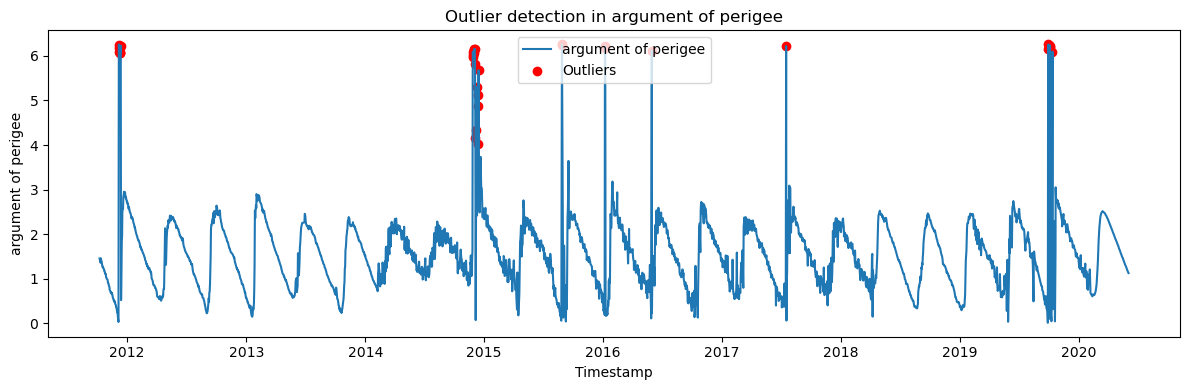

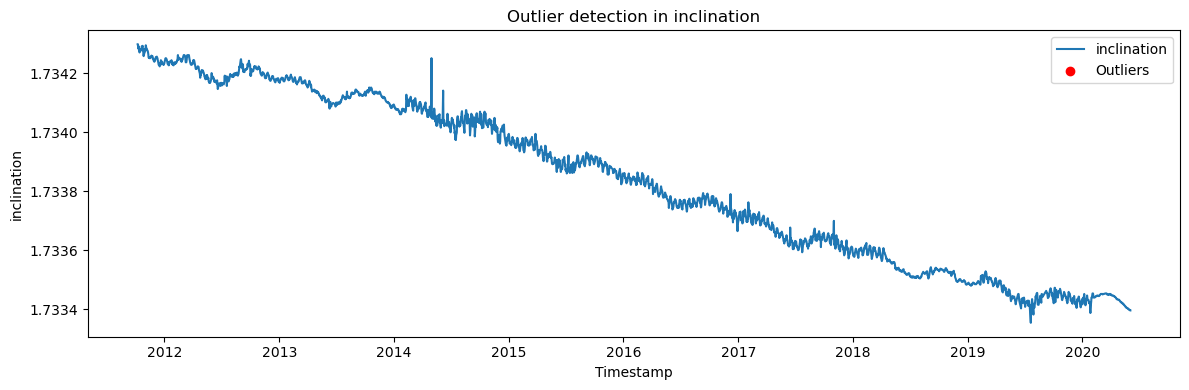

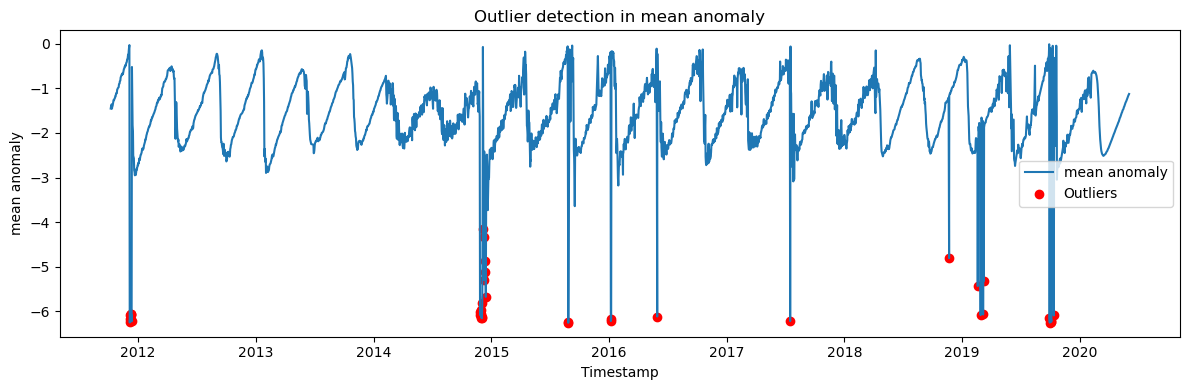

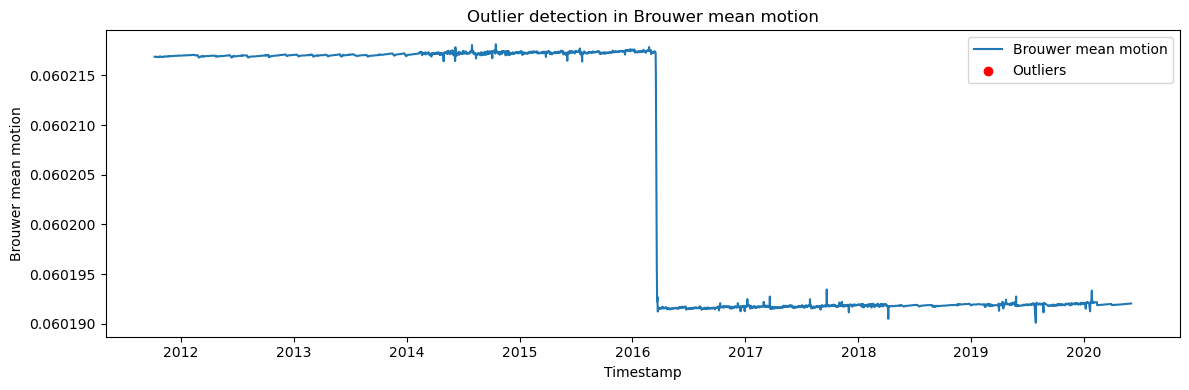

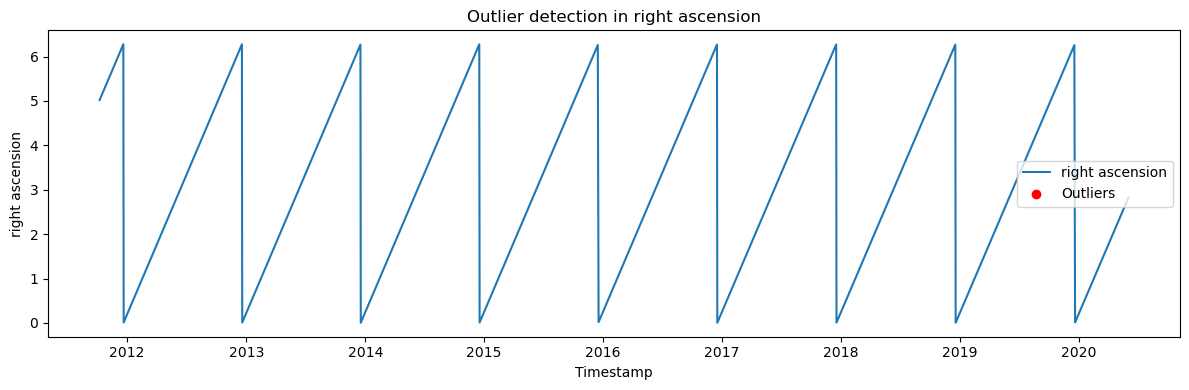

In [8]:
# Detecting outliers using z_scores   

def outlier_detection(df, threshold=3):  # applying standard threshold 3
    z_scores = df.apply(zscore) 
    outliers = (z_scores.abs() > threshold)
    return outliers

def plot_outliers(df, outliers):
    for col in df.columns:
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df[col], label=col)
        plt.scatter(df.index[outliers[col]], df[col][outliers[col]], color='red', label='Outliers')
        plt.title(f"Outlier detection in {col}")
        plt.legend()
        plt.xlabel("Timestamp")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
outliers = outlier_detection(orb_df)
plot_outliers(orb_df, outliers)

Have detected some outliers in eccentricity, argument of perigee and mean anomaly


Descriptive Statistics:
       eccentricity  argument of perigee  inclination  mean anomaly  \
count   2998.000000          2998.000000  2998.000000   2998.000000   
mean       0.000118             1.562484     1.733842     -1.566304   
std        0.000058             0.806231     0.000276      0.822871   
min        0.000002             0.014502     1.733355     -6.256930   
25%        0.000073             0.999030     1.733589     -2.093253   
50%        0.000125             1.543238     1.733850     -1.541934   
75%        0.000158             2.092170     1.734109     -0.996536   
max        0.000375             6.259006     1.734299     -0.012350   

       Brouwer mean motion  right ascension  
count          2998.000000      2998.000000  
mean              0.060205         3.085059  
std               0.000013         1.841693  
min               0.060190         0.002562  
25%               0.060192         1.479528  
50%               0.060217         2.992357  
75%          

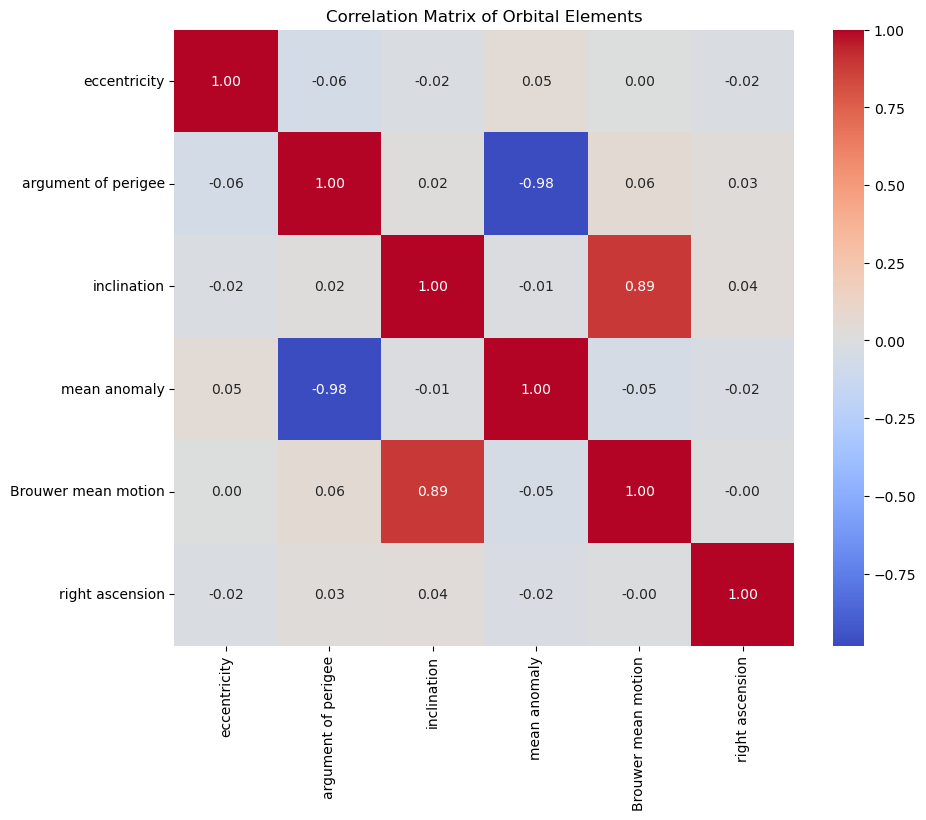

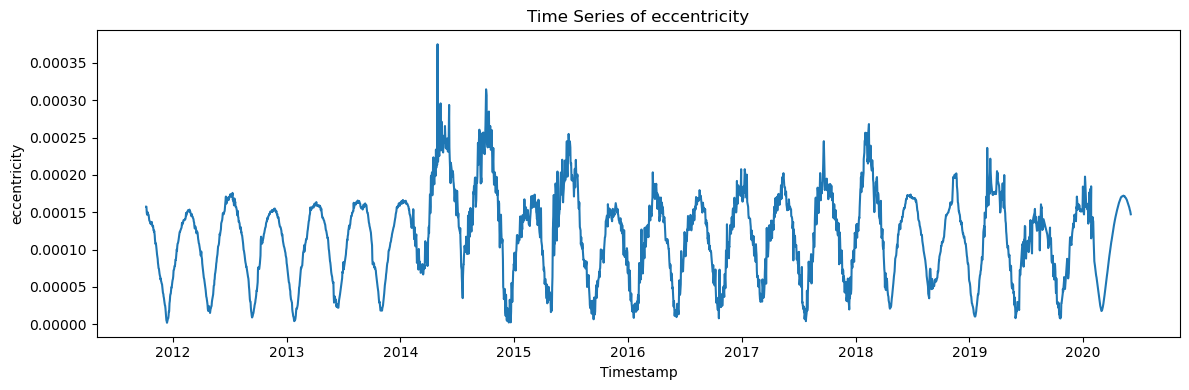

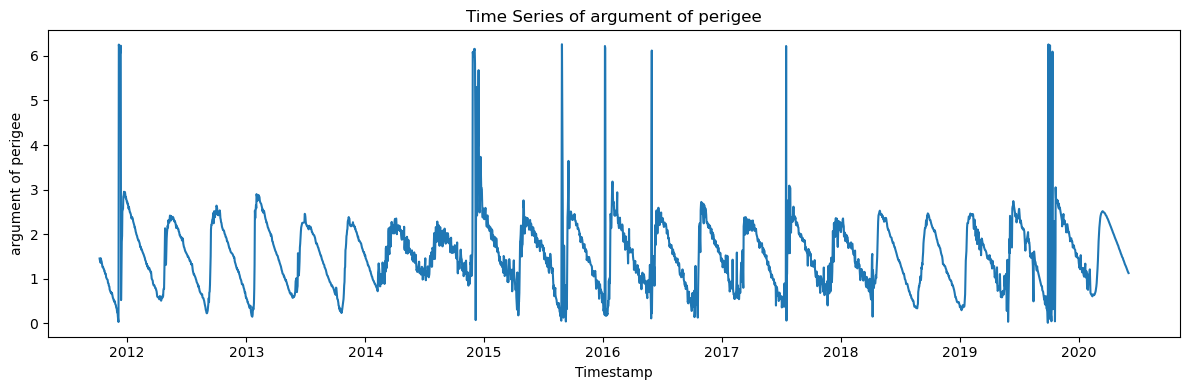

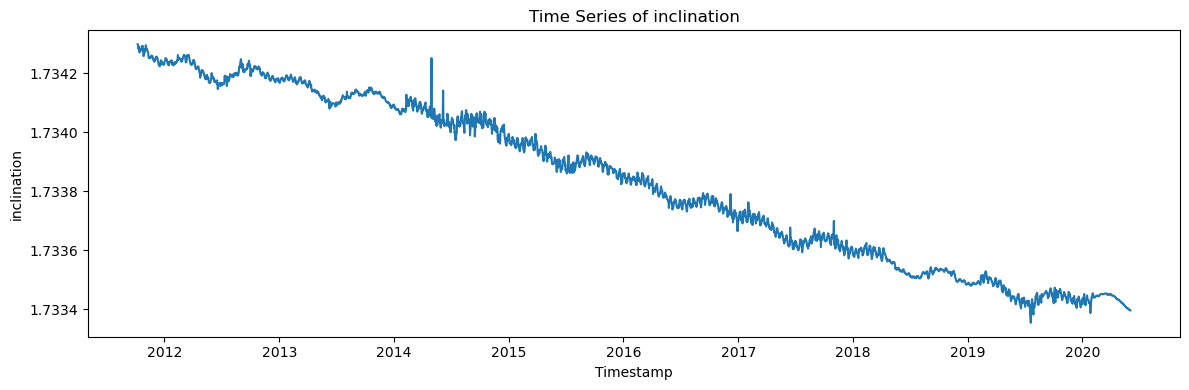

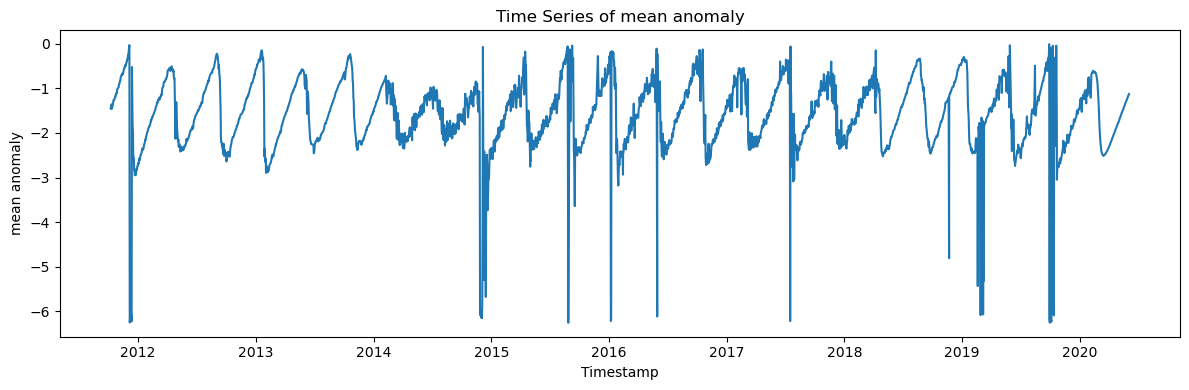

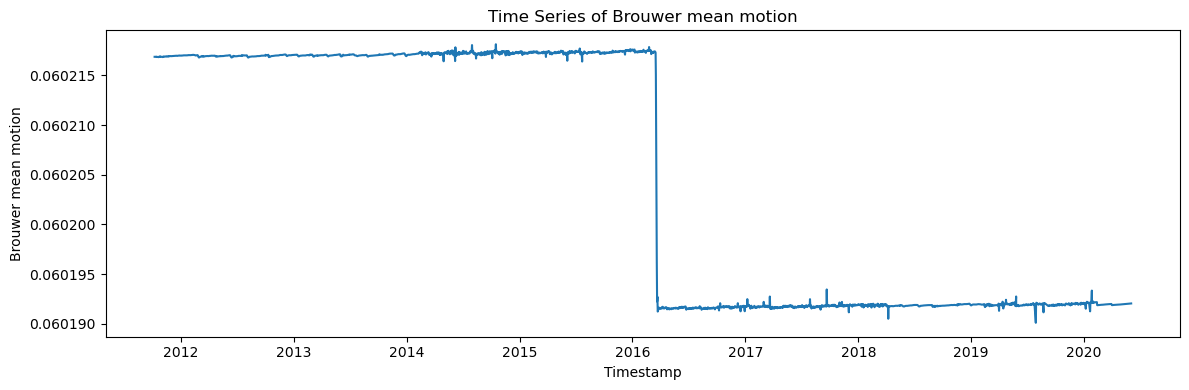

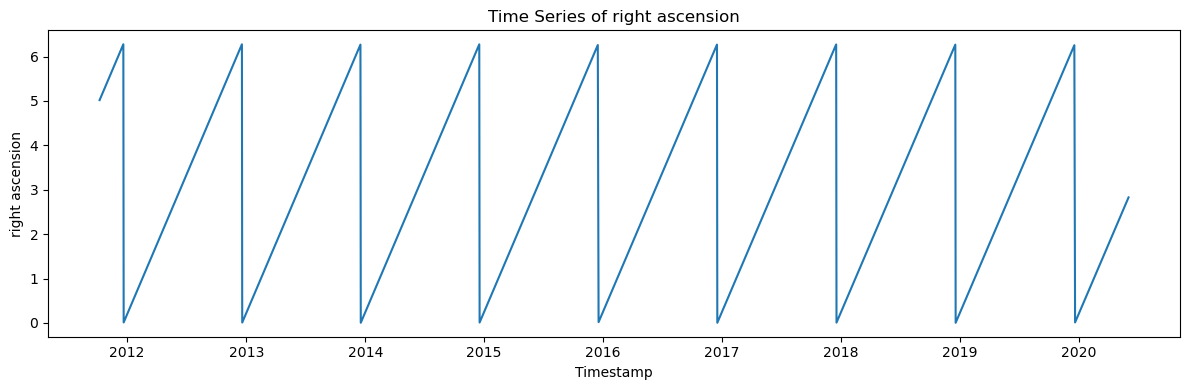

In [9]:
# EDA for all orbital elements

def exploratory_analysis(df):
    print("\nDescriptive Statistics:")
    print(df.describe())

    print("\nNull Values:")
    print(df.isnull().sum())

    print("\nCorrelation Matrix:")
    corr = df.corr()
    print(corr)

    # Heatmap of correlations to see the correlation between the orbital elements.
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Orbital Elements")
    plt.show()

    # Time-series trend plot of all orbital elements.
    for col in df.columns:
        plt.figure(figsize=(12, 4))
        sns.lineplot(x=df.index, y=df[col])
        plt.title(f"Time Series of {col}")
        plt.xlabel("Timestamp")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
exploratory_analysis(orb_df)

Mean anomaly will be most suitable as it has high variance and low correlation. But I have selected inclination for detetcion here since I have tried mean anomaly in CryosSat-2 satellite.
Inclination has almost no correlation and its stable. There is no missing values which is evident from the Null Values, hence ARIMA can be applied without any imputation. But will be checkig stationarity and do differencing if needed before modelling.

<Figure size 1000x400 with 0 Axes>

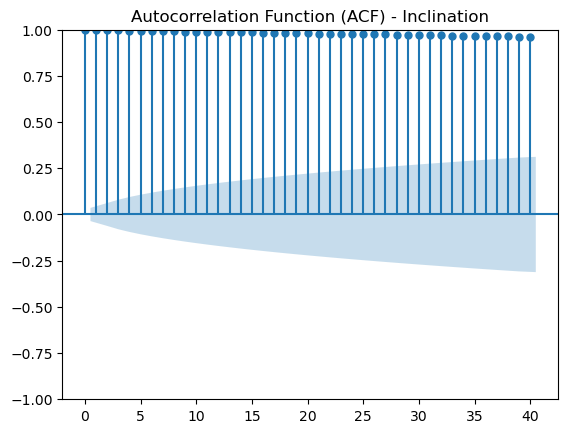

<Figure size 1000x400 with 0 Axes>

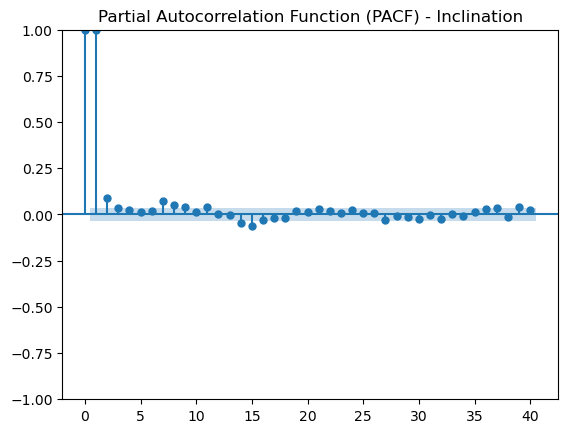

Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).
Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).


--- Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic     : -0.252252
p-value           : 0.932000
Critical Values   :
   1%: -3.4325
   5%: -2.8625
   10%: -2.5673

 The series is NOT stationary.

Conclusion: Fail to reject the null hypothesis (H₀). The series is non-stationary at the 5% significance level.


In [10]:
# Checking stationarity of 'inclination' using ACF and PACF plots

series = orb_df['inclination'].dropna()

# ACF plot
plt.figure(figsize=(10, 4))
plot_acf(series, lags=40)
plt.title('Autocorrelation Function (ACF) - Inclination')
plt.show()

# PACF plot
plt.figure(figsize=(10, 4))
plot_pacf(series, lags=40, method='ywm') 
plt.title('Partial Autocorrelation Function (PACF) - Inclination')
plt.show()

# ADF Test

# Print hypotheses
print("Null Hypothesis (H₀): The time series is non-stationary (contains a unit root).")
print("Alternative Hypothesis (H₁): The time series is stationary (does not contain a unit root).\n")
result = adfuller(series)
print('\n--- Augmented Dickey-Fuller (ADF) Test ---')
print(f"ADF Statistic     : {result[0]:.6f}")
print(f"p-value           : {result[1]:.6f}")
print(f"Critical Values   :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")
if result[1] < 0.05:
    print("\n The series is stationary.")
else:
    print("\n The series is NOT stationary.")
# Conclusion
if result[1] <= 0.05:
    print("\nConclusion: Reject the null hypothesis (H₀). The series is stationary at the 5% significance level.")
else:
    print("\nConclusion: Fail to reject the null hypothesis (H₀). The series is non-stationary at the 5% significance level.")



### Since the series is not stationary we will be doing differencing

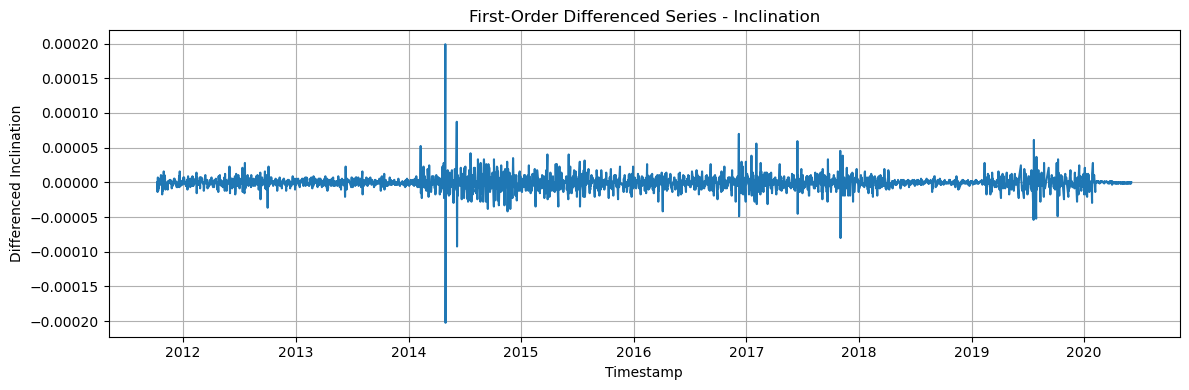


 ADF Test After Differencing
ADF Statistic     : -14.063248
p-value           : 0.000000
Critical Values   :
   1%: -3.4325
   5%: -2.8625
   10%: -2.5673

 The differenced series is stationary.


In [11]:
# First order differencing

# First order differencing
series = orb_df['inclination'].dropna()
diff_series = series.diff().dropna()

# Plotting the differenced series
plt.figure(figsize=(12, 4))
plt.plot(diff_series)
plt.title('First-Order Differenced Series - Inclination')
plt.xlabel('Timestamp')
plt.ylabel('Differenced Inclination')
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test on differenced series
print('\n ADF Test After Differencing')
result = adfuller(diff_series)
print(f"ADF Statistic     : {result[0]:.6f}")
print(f"p-value           : {result[1]:.6f}")
print(f"Critical Values   :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")
if result[1] < 0.05:
    print("\n The differenced series is stationary.")
else:
    print("\n The differenced series is still not stationary.")


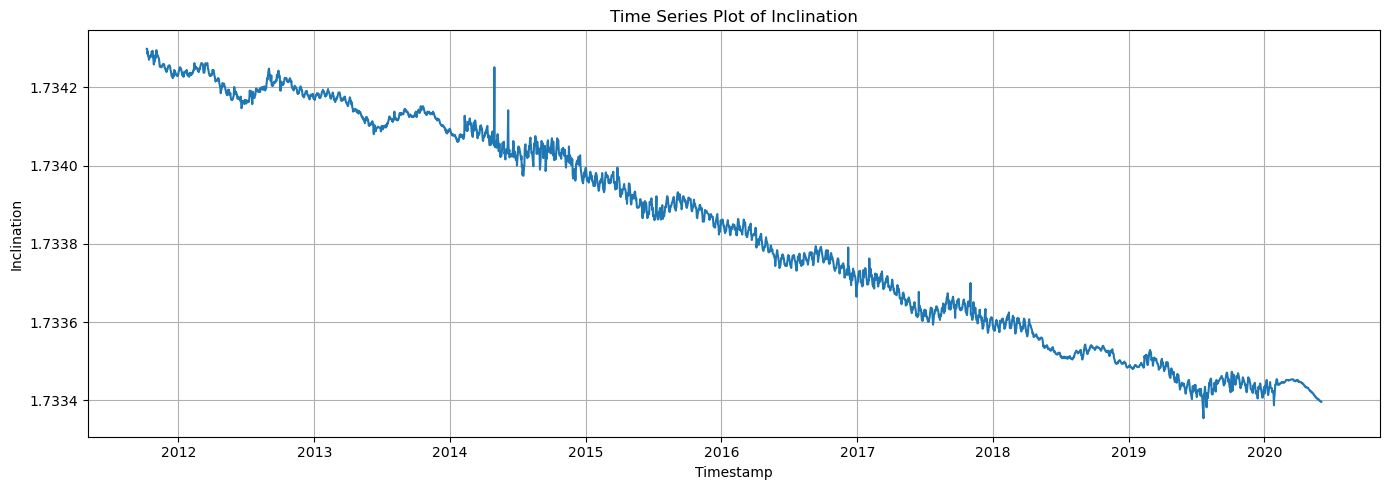

In [12]:
# Plotting the trend only for the selected orbital element inclination.

def plot_trend(df):
    plt.figure(figsize=(14, 5))
    sns.lineplot(x=df.index, y=df['inclination'])
    plt.title("Time Series Plot of Inclination")
    plt.xlabel("Timestamp")
    plt.ylabel("Inclination")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_trend(orb_df)

In [13]:
# Fill missing values in mean_anomaly
if orb_df['inclination'].isna().sum() > 0:
    orb_df['inclination'] = orb_df['inclination'].fillna(method='ffill')

In [14]:
# Stationarity check

In [15]:
def stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'{title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Result: {"Stationary" if result[1] < 0.05 else "Non-stationary"}')
    print("\n")
    return result[1] < 0.05

is_stationary = stationarity(orb_df['inclination'], "Original Mean Anomaly")

# Resample to daily frequency 
inclination_daily = orb_df['inclination'].resample('D').mean().ffill()

# --- Decompose time series ---
from statsmodels.tsa.seasonal import seasonal_decompose

period = 30  
decomposition = seasonal_decompose(inclination_daily, model='additive', period=period)

Original Mean Anomaly
ADF Statistic: -0.2523
p-value: 0.9320
Result: Non-stationary




In [16]:
# Decomposing for inclination

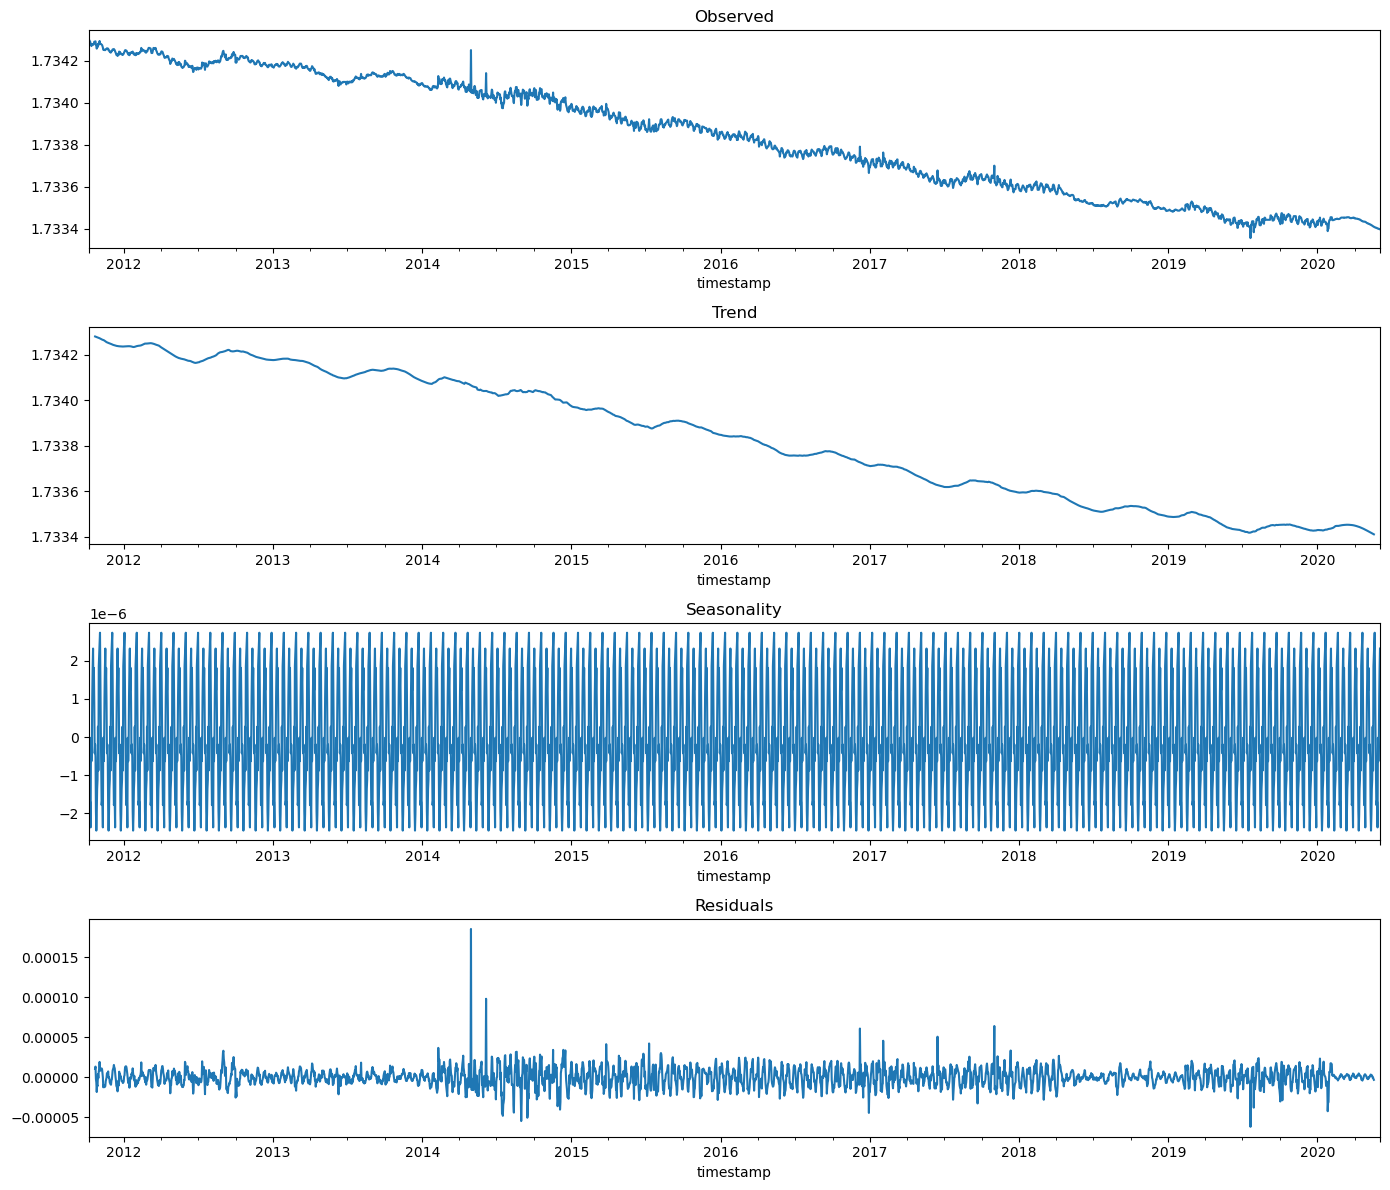

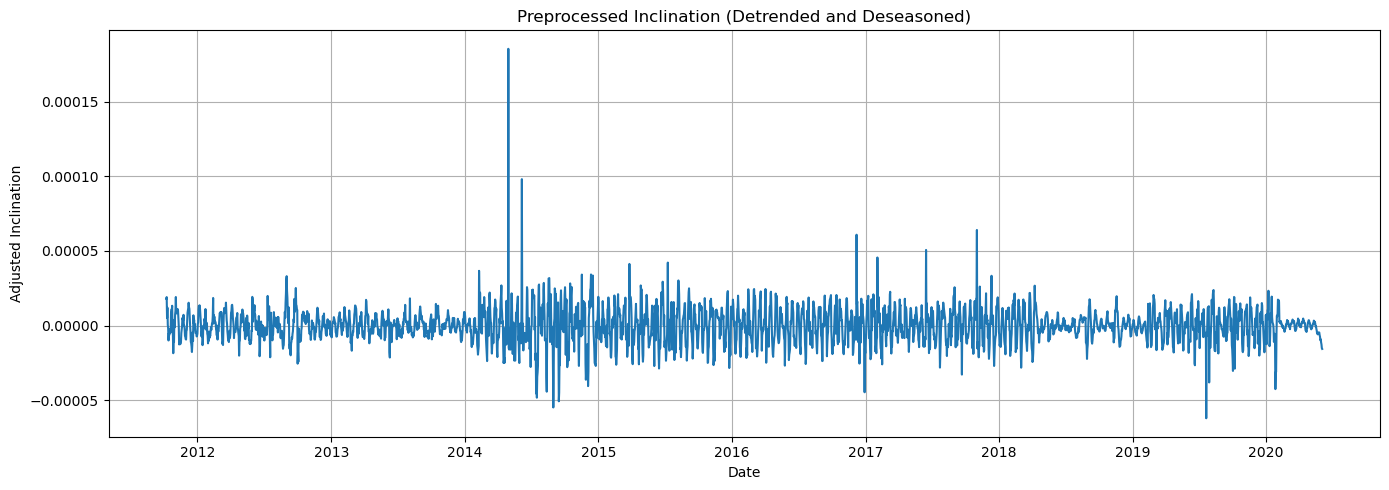

Preprocessed Inclination
ADF Statistic: -14.0623
p-value: 0.0000
Result: Stationary




In [17]:
# Plot decomposition 
# Plotting observed, Trend, Seasonality and Residuals
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residuals')
plt.tight_layout()
plt.show()

# Preprocessing: detrend and deseason
trend = decomposition.trend.ffill().bfill()
seasonal = decomposition.seasonal.ffill().bfill()
detrended_deseasoned = inclination_daily - trend - seasonal

# Plotting preprocessed mean anomaly
plt.figure(figsize=(14, 5))
plt.plot(detrended_deseasoned.index, detrended_deseasoned.values)
plt.title("Preprocessed Inclination (Detrended and Deseasoned)")
plt.xlabel("Date")
plt.ylabel("Adjusted Inclination")
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing stationarity of the preprocessed data
is_preprocessed_stationary = stationarity(detrended_deseasoned.dropna(), "Preprocessed Inclination")

# Final preprocessed data
preprocessed_data = detrended_deseasoned.dropna()


In [18]:
# Train-test split (80% for training, 20% for testing)

train_size = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:train_size]
test_data = preprocessed_data[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (2528,)
Test data shape: (633,)


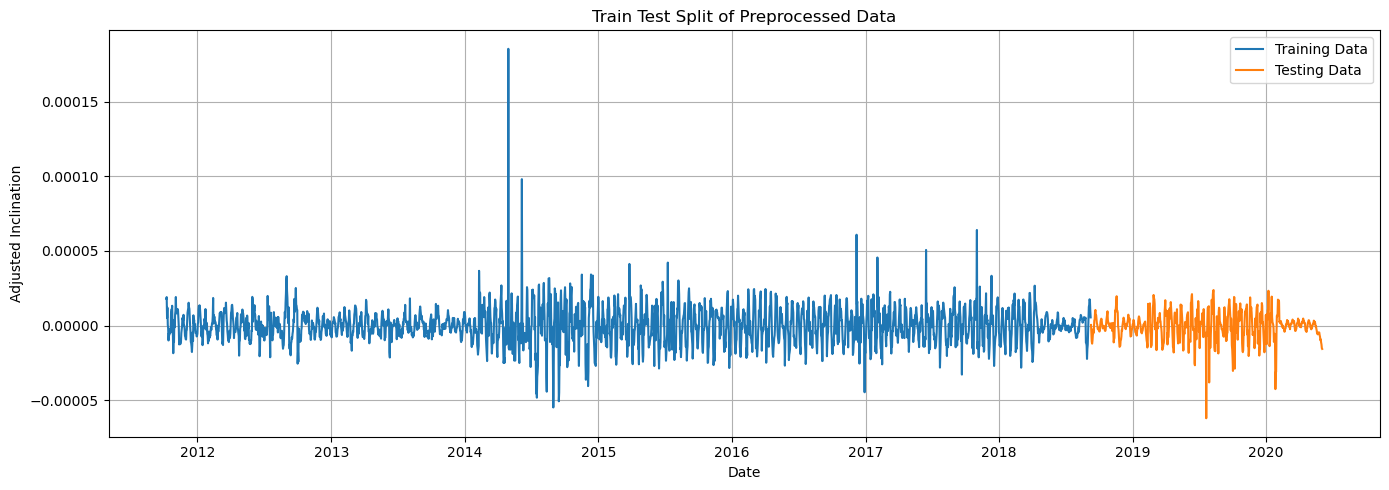

In [19]:
# Plotting the train test split
plt.figure(figsize=(14, 5))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.title("Train Test Split of Preprocessed Data")
plt.xlabel("Date")
plt.ylabel("Adjusted Inclination")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Grid search

In [21]:
# Cleaning the data 
train_series = train_data.dropna()
train_series = train_series.astype(float)

In [22]:
def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    best_aic = float("inf")
    results = []

    warnings.filterwarnings("ignore") # This step is to suppress warnings

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(data, order=(p, d, q),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    
                    results.append({
                        'order': (p, d, q),
                        'aic': aic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_cfg = (p, d, q)
                    
                    print(f"ARIMA({p},{d},{q}) - AIC: {aic:.4f}")
                except Exception as e:
                    print(f"Error with ARIMA({p},{d},{q}): {str(e)}")
                    continue

    warnings.filterwarnings("default") # enabling warnings
    
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df = results_df.sort_values('aic')
        print("\nTop 5 ARIMA Models:")
        print(results_df.head())
    
    print(f"\nBest ARIMA Model: {best_cfg} with AIC: {best_aic:.4f}")
    return best_cfg

# Defining parameter ranges
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_order = grid_search_arima(train_data, p_values, d_values, q_values)


ARIMA(0,0,0) - AIC: -44815.8288
ARIMA(0,0,1) - AIC: -50654.3373
ARIMA(0,0,2) - AIC: -50927.0620
ARIMA(0,0,3) - AIC: -50970.9911
ARIMA(0,1,0) - AIC: -50479.6277
ARIMA(0,1,1) - AIC: -50583.4600
ARIMA(0,1,2) - AIC: -50570.6899
ARIMA(0,1,3) - AIC: -50567.5163
ARIMA(0,2,0) - AIC: -48524.7923
ARIMA(0,2,1) - AIC: -40773.9777
ARIMA(0,2,2) - AIC: -50419.3514
ARIMA(0,2,3) - AIC: -48502.0129
ARIMA(1,0,0) - AIC: -51065.2859
ARIMA(1,0,1) - AIC: -51042.8082
ARIMA(1,0,2) - AIC: -50984.5265
ARIMA(1,0,3) - AIC: -50795.5634
ARIMA(1,1,0) - AIC: -50585.3961
ARIMA(1,1,1) - AIC: -50571.3297
ARIMA(1,1,2) - AIC: -50476.6067
ARIMA(1,1,3) - AIC: -49947.8556
ARIMA(1,2,0) - AIC: -49070.3608
ARIMA(1,2,1) - AIC: -50397.4420
ARIMA(1,2,2) - AIC: -49490.6036
ARIMA(1,2,3) - AIC: -49908.9585
ARIMA(2,0,0) - AIC: -51042.8243
ARIMA(2,0,1) - AIC: -34568.0313
ARIMA(2,0,2) - AIC: -49536.7523
ARIMA(2,0,3) - AIC: -50745.1714
ARIMA(2,1,0) - AIC: -50582.2929
ARIMA(2,1,1) - AIC: -50178.2289
ARIMA(2,1,2) - AIC: -46990.0304
ARIMA(2,

In [23]:
# Training the best model on training data

# Summary of best model
best_model = ARIMA(train_data, order=best_order)
best_model_fit = best_model.fit()
print("Best model summary:")
print(best_model_fit.summary())

# Predicting on test data
predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")

Best model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2528
Model:                 ARIMA(1, 0, 0)   Log Likelihood               25544.960
Date:                Fri, 15 Aug 2025   AIC                         -51083.920
Time:                        14:05:00   BIC                         -51066.414
Sample:                    10-08-2011   HQIC                        -51077.568
                         - 09-08-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.314e-08   4.89e-07     -0.027      0.979   -9.72e-07    9.46e-07
ar.L1          0.5973   1.53e-11   3.89e+10      0.000       0.597       0.597
sigma2      9.757e-11   3.85e-11

/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Trying future predictions 
future_steps = 30 
future_index = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
future_forecast = best_model_fit.forecast(steps=future_steps)

Recompose the predictions and future forecasts back into original scale by adding back the trend and seasonality to predict on residuals

In [27]:
# Recomposing the predictions and future forecasts

def recompose_series(decomposed_values, trend_series, seasonal_series, dates):
    recomposed = []
    for i, date in enumerate(dates):
     
        trend_value = trend_series.get(date, trend_series.iloc[-1] if date > trend_series.index[-1] else trend_series.iloc[0])
        
        
        seasonal_idx = (i % len(seasonal_series)) if len(seasonal_series) > 0 else 0
        seasonal_value = seasonal_series.iloc[seasonal_idx]
        
    
        recomposed_value = decomposed_values.iloc[i] + trend_value + seasonal_value
        recomposed.append(recomposed_value)
    
    return recomposed

# Create recomposed series for visualisations
recomposed_test_dates = test_data.index
recomposed_future_dates = future_index


test_trend = trend.reindex(recomposed_test_dates, method='nearest')
test_seasonal_pattern = seasonal.iloc[:len(seasonal)]


future_trend = pd.Series([trend.iloc[-1]] * len(future_index), index=future_index)


recomposed_predictions = recompose_series(
    pd.Series(predictions, index=recomposed_test_dates),
    test_trend, 
    test_seasonal_pattern, 
    recomposed_test_dates
)

recomposed_future = recompose_series(
    pd.Series(future_forecast, index=future_index), 
    future_trend, 
    test_seasonal_pattern, 
    recomposed_future_dates
)


In [28]:
# Plotting both the original scale and the preprocessed scale data

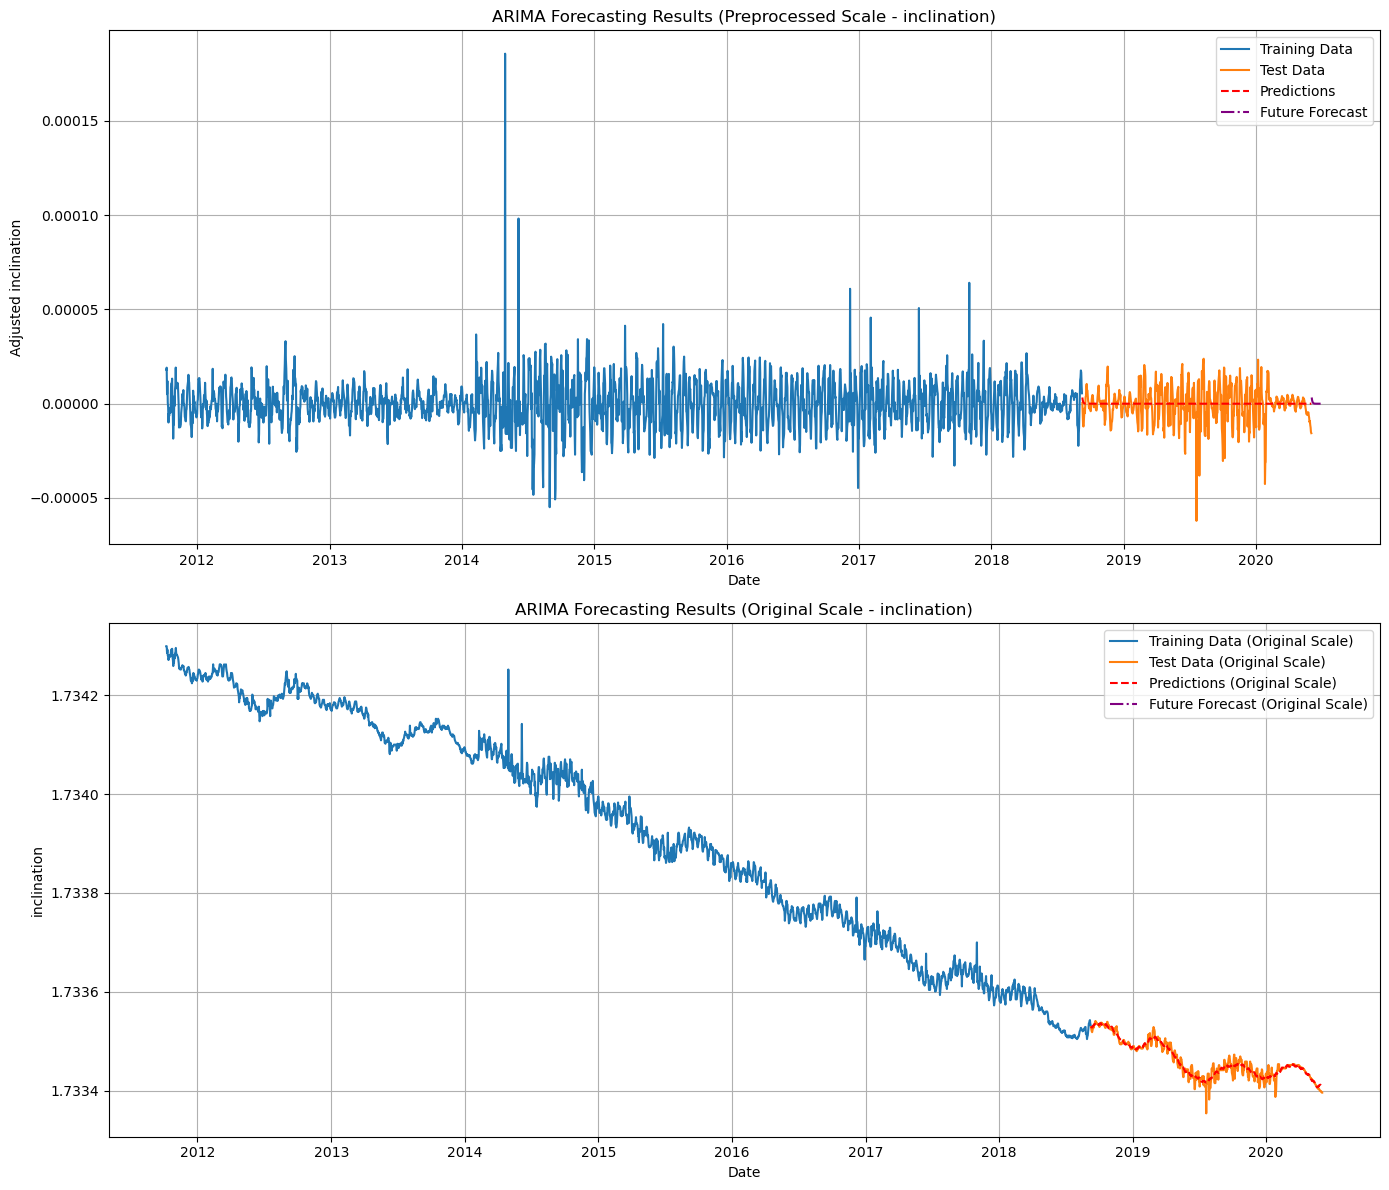

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plotting the preprocessed scale which is detrended and deseasoned
axes[0].plot(train_data.index, train_data, label='Training Data')
axes[0].plot(test_data.index, test_data, label='Test Data')
axes[0].plot(test_data.index, predictions, label='Predictions', color='red', linestyle='--')
axes[0].plot(future_index, future_forecast, label='Future Forecast', color='purple', linestyle='-.')
axes[0].set_title("ARIMA Forecasting Results (Preprocessed Scale - inclination)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Adjusted inclination")
axes[0].legend()
axes[0].grid(True)

# Plotting the original scale recomposed with trend and seasonality
axes[1].plot(inclination_daily.index[:train_size], inclination_daily.iloc[:train_size], 
             label='Training Data (Original Scale)')
axes[1].plot(test_data.index, inclination_daily.reindex(test_data.index), 
             label='Test Data (Original Scale)')
axes[1].plot(test_data.index, recomposed_predictions, 
             label='Predictions (Original Scale)', color='red', linestyle='--')
axes[1].plot(future_index, recomposed_future, 
             label='Future Forecast (Original Scale)', color='purple', linestyle='-.')
axes[1].set_title("ARIMA Forecasting Results (Original Scale - inclination)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("inclination")
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()


In [30]:
# residuals - difference between forecasts and actual values

In [31]:
# Calculating residuals 
test_predictions = best_model_fit.predict(start=test_data.index[0], end=test_data.index[-1])
residuals = test_data - test_predictions

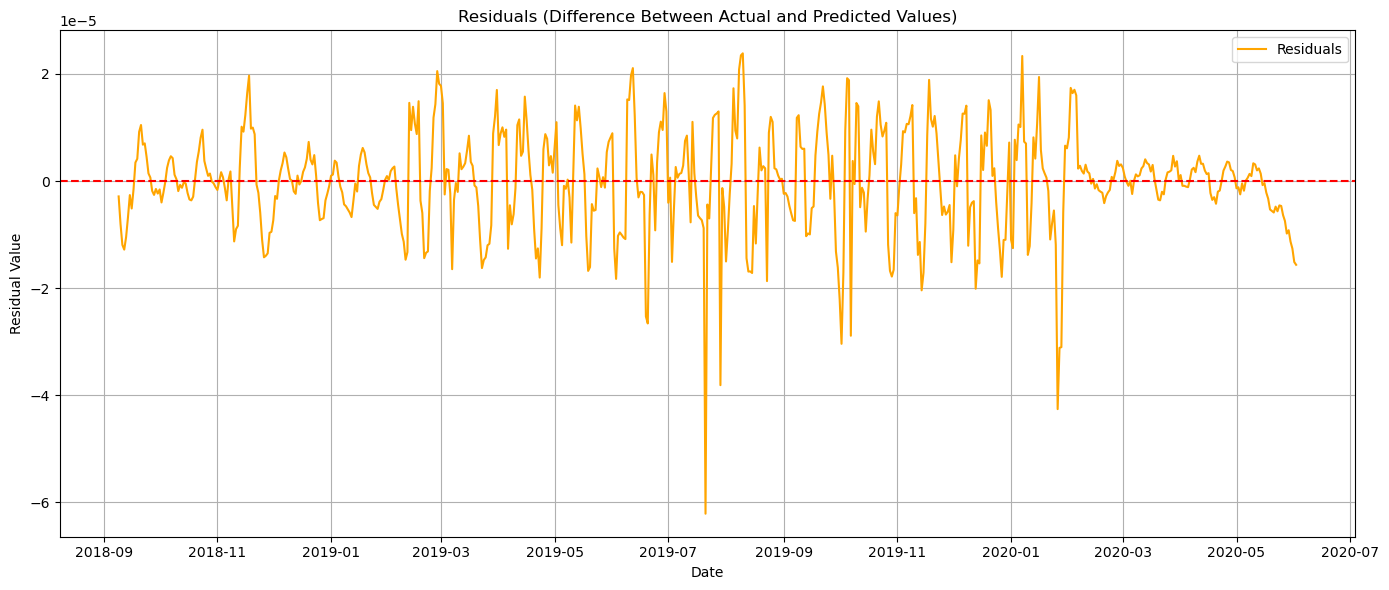

In [32]:
# 1. Plotting the residuals
plt.figure(figsize=(14, 6))
plt.plot(residuals.index, residuals, label='Residuals', color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals (Difference Between Actual and Predicted Values)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Implementing manoeuvre detection

In [34]:
# Absolute residuals
abs_residuals = np.abs(residuals)

# Threshold using standard deviation
threshold = abs_residuals.mean() + 2 * abs_residuals.std()

# Detecting manoeuvres where residuals exceed threshold
detected_manoeuvres = residuals[abs_residuals > threshold]

print(f"Threshold value: {threshold:.8f}")
print(f"Number of detected manoeuvres: {len(detected_manoeuvres)}")

Threshold value: 0.00001967
Number of detected manoeuvres: 20


#### Grouping consecutive manoeuvre detected points within 1-2 days to a single manoeuvre event as most of the satellite manoeuvre takes not just one time stamp but takes place for some duration.

In [35]:
detected_dates = detected_manoeuvres.index.tolist()
manoeuvre_events = []

if detected_dates:
    current_event = [detected_dates[0]]
    
    for i in range(1, len(detected_dates)):
        # if within 2 days
        if (detected_dates[i] - current_event[-1]).days <= 2:  
            current_event.append(detected_dates[i])
        else:
            # else its the end of current event and start a new one
            manoeuvre_events.append({
                'start_time': current_event[0],
                'end_time': current_event[-1],
                'max_residual': abs_residuals[current_event].max()
            })
            current_event = [detected_dates[i]]
    
    # Adding the last event
    manoeuvre_events.append({
        'start_time': current_event[0],
        'end_time': current_event[-1],
        'max_residual': abs_residuals[current_event].max()
    })

detected_df = pd.DataFrame(manoeuvre_events)

#### Plotting detected manoeuvres against ground truth

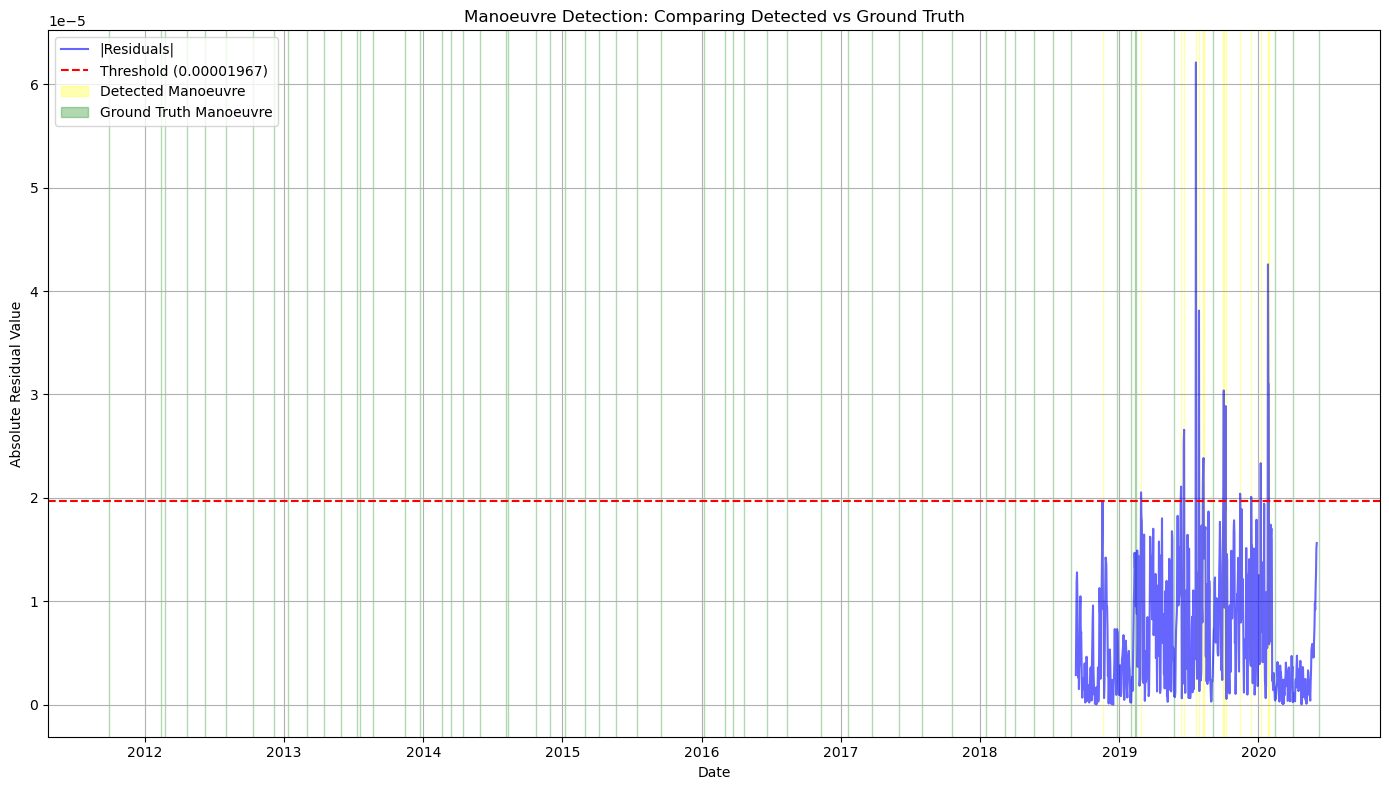

In [36]:
plt.figure(figsize=(14, 8))

# Plotting absolute residuals
plt.plot(abs_residuals.index, abs_residuals, label='|Residuals|', color='blue', alpha=0.6)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.8f})')

# Plotting detected manoeuvres
for idx, event in enumerate(manoeuvre_events):
    plt.axvspan(event['start_time'], event['end_time'], 
                alpha=0.3, color='yellow', label='Detected Manoeuvre' if idx == 0 else '')

# Plotting ground truth manoeuvres
for idx, row in man_df.iterrows():
    plt.axvspan(row['start_time'], row['end_time'], 
                alpha=0.3, color='green', label='Ground Truth Manoeuvre' if idx == 0 else '')

plt.title('Manoeuvre Detection: Comparing Detected vs Ground Truth')
plt.xlabel('Date')
plt.ylabel('Absolute Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Calculating accuracy metrics

In [37]:
# Quantitative metrics
def calculate_accuracy(detected_df, ground_truth_df, tolerance_days=3):
    true_positives = 0
    false_positives = 0
    
    # For each detected event, check if it's close to a ground truth manoeuvre to get the true and fasle positives
    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        
        if matched:
            true_positives += 1
        else:
            false_positives += 1
    
    # Counting false negatives where ground truth events not detected
    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or            
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break  
        if not matched:
            false_negatives += 1
    
    # Calculating metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

In [38]:
# Printing all the detection accuracy metrics
accuracy_metrics = calculate_accuracy(detected_df, man_df)
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")


Manoeuvre Detection Performance:
True Positives: 0
False Positives: 13
False Negatives: 58
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [40]:
# Quantitative metrics
def calculate_accuracy(detected_df, ground_truth_df, total_possible_events, tolerance_days=3):
    true_positives = 0
    false_positives = 0


    for _, det_event in detected_df.iterrows():
        matched = False
        for _, gt_event in ground_truth_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break
        
        if matched:
            true_positives += 1
        else:
            false_positives += 1

    # Counting false negatives where ground truth events not detected
    false_negatives = 0
    for _, gt_event in ground_truth_df.iterrows():
        matched = False
        for _, det_event in detected_df.iterrows():
            if (
                (det_event['start_time'] <= gt_event['end_time'] and 
                 det_event['end_time'] >= gt_event['start_time']) or            
                (abs((det_event['start_time'] - gt_event['start_time']).days) <= tolerance_days or
                 abs((det_event['end_time'] - gt_event['end_time']).days) <= tolerance_days)
            ):
                matched = True
                break  
        if not matched:
            false_negatives += 1

    
    true_negatives = total_possible_events - (true_positives + false_positives + false_negatives)

    # Calculating metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / total_possible_events if total_possible_events > 0 else 0

    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy
    }


total_possible_events = 109 

accuracy_metrics = calculate_accuracy(detected_df, man_df, total_possible_events)

# Printing all the detection accuracy metrics
print("\nManoeuvre Detection Performance:")
print(f"True Positives: {accuracy_metrics['true_positives']}")
print(f"False Positives: {accuracy_metrics['false_positives']}")
print(f"False Negatives: {accuracy_metrics['false_negatives']}")
print(f"True Negatives: {accuracy_metrics['true_negatives']}")
print(f"Precision: {accuracy_metrics['precision']:.4f}")
print(f"Recall: {accuracy_metrics['recall']:.4f}")
print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")
print(f"Accuracy: {accuracy_metrics['accuracy']:.4f}")



Manoeuvre Detection Performance:
True Positives: 0
False Positives: 13
False Negatives: 58
True Negatives: 38
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.3486


/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/priyasebastian/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


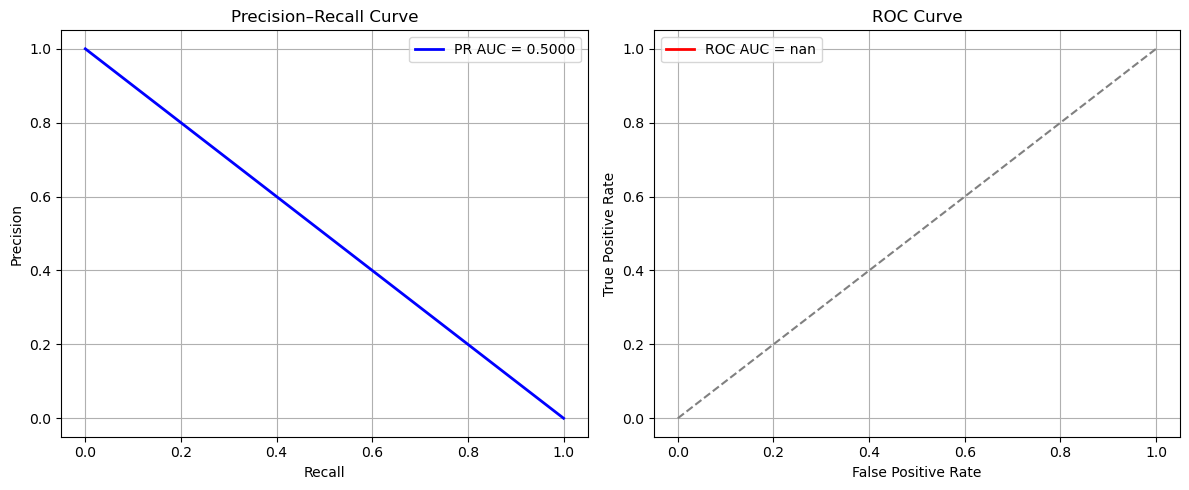

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

ground_truth_labels = []
for date in abs_residuals.index:
    in_manoeuvre = any(
        (date >= row['start_time']) and (date <= row['end_time'])
        for _, row in man_df.iterrows()
    )
    ground_truth_labels.append(1 if in_manoeuvre else 0)

scores = abs_residuals.values

# Compute Precision Recall curve
precision, recall, pr_thresholds = precision_recall_curve(ground_truth_labels, scores)
pr_auc = auc(recall, precision)

# Compute ROC 
fpr, tpr, roc_thresholds = roc_curve(ground_truth_labels, scores)
roc_auc_value = auc(fpr, tpr)

# Plot Precision Recall curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC AUC = {roc_auc_value:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:
# Printing summary table comparing detected vs ground truth manoeuvres
print("\nDetected Manoeuvres:")
print(detected_df[['start_time', 'end_time', 'max_residual']])

print("\nGround Truth Manoeuvres:")
print(man_df[['start_time', 'end_time']])


Detected Manoeuvres:
   start_time   end_time  max_residual
0  2018-11-18 2018-11-18      0.000020
1  2019-02-27 2019-02-27      0.000021
2  2019-06-11 2019-06-12      0.000021
3  2019-06-19 2019-06-20      0.000027
4  2019-07-21 2019-07-21      0.000062
5  2019-07-29 2019-07-29      0.000038
6  2019-08-08 2019-08-10      0.000024
7  2019-10-01 2019-10-02      0.000030
8  2019-10-07 2019-10-07      0.000029
9  2019-11-14 2019-11-14      0.000020
10 2019-12-13 2019-12-13      0.000020
11 2020-01-07 2020-01-07      0.000023
12 2020-01-26 2020-01-28      0.000043

Ground Truth Manoeuvres:
            start_time            end_time
0  2011-09-28 16:20:00 2011-09-28 16:20:00
1  2012-02-14 03:05:00 2012-02-14 03:05:00
2  2012-02-24 03:20:00 2012-02-24 03:20:00
3  2012-04-20 03:20:00 2012-04-20 03:20:00
4  2012-06-08 02:35:00 2012-06-08 02:35:00
5  2012-08-01 03:25:00 2012-08-01 03:25:00
6  2012-10-10 03:26:00 2012-10-10 03:26:00
7  2012-12-05 01:50:00 2012-12-05 01:50:00
8  2013-01-11 03:20

In [43]:
# Plotting detected manoeuvre vs. ground truth

In [44]:
# Fitering the ground truth manoeuvres which comes in between the residual time frame during plotting
man_df_filtered = man_df[
    (man_df['start_time'] >= residuals.index.min()) &
    (man_df['end_time'] <= residuals.index.max())
]

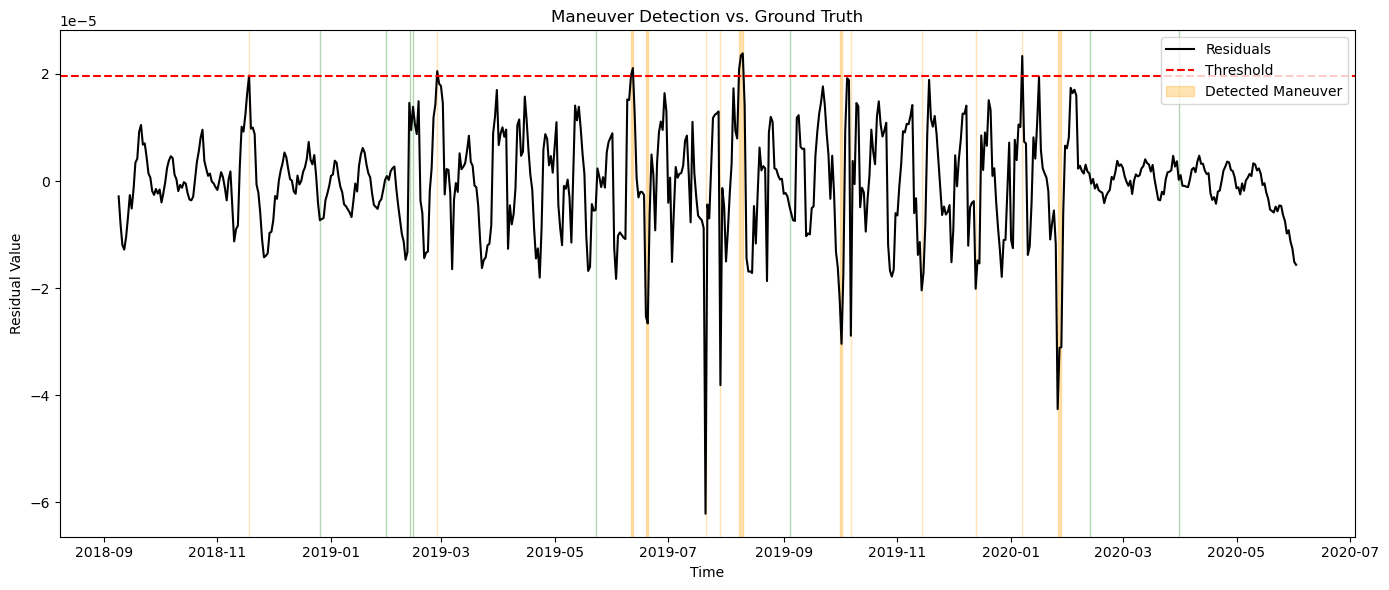

In [45]:
plt.figure(figsize=(14, 6))

# residuals
plt.plot(residuals.index, residuals.values, label='Residuals', color='black')

# threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# detected maneuvers
if not detected_df.empty:
    for idx, row in detected_df.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='orange', alpha=0.3,
                    label='Detected Maneuver' if idx == 0 else "")

# ground truth maneuvers
if not man_df_filtered.empty:
    for idx, row in man_df_filtered.iterrows():
        plt.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.3,
                    label='Ground Truth Maneuver' if idx == 0 else "")

plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.title('Maneuver Detection vs. Ground Truth')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


#### Detetcting anomaly

In [46]:
# detecting anomaly by checking if the value exceeds the threshold.

In [49]:
def detect_anomalies(residuals, threshold):
    anomalies = []
    in_anomaly = False
    start_time = None
    for time, value in residuals.items():
        if abs(value) > threshold:
            if not in_anomaly:
                in_anomaly = True
                start_time = time
        else:
            if in_anomaly:
                in_anomaly = False
                end_time = time
                anomalies.append({'start_time': start_time, 'end_time': end_time})
    

    if in_anomaly:
        anomalies.append({'start_time': start_time, 'end_time': residuals.index[-1]})
    
    return pd.DataFrame(anomalies)

anomalies_df = detect_anomalies(residuals, threshold)
print(anomalies_df)

   start_time   end_time
0  2018-11-18 2018-11-19
1  2019-02-27 2019-02-28
2  2019-06-11 2019-06-13
3  2019-06-19 2019-06-21
4  2019-07-21 2019-07-22
5  2019-07-29 2019-07-30
6  2019-08-08 2019-08-11
7  2019-10-01 2019-10-03
8  2019-10-07 2019-10-08
9  2019-11-14 2019-11-15
10 2019-12-13 2019-12-14
11 2020-01-07 2020-01-08
12 2020-01-26 2020-01-29


In [50]:
# Plotting the particular points of anomaly

In [51]:
# Detecting the particular point of anomaly to plot
def detect_anomalies(residuals, threshold):
    anomaly_mask = residuals.abs() > threshold
    return residuals[anomaly_mask]

def plot_all_in_one(observed, predicted, residuals, threshold, man_df):
    anomalies = detect_anomalies(residuals, threshold)

    fig, ax = plt.subplots(figsize=(16, 6))

# Plotting Observed & Predicted
    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)

# Plotting residuals 
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.4, label='Residuals')

# Plotting anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

# Plotting threshold
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=-threshold, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Plotting ground truth maneuvers
    for idx, row in man_df.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == 0 else "")

    ax.set_title("Anomaly Detection with Ground Truth")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

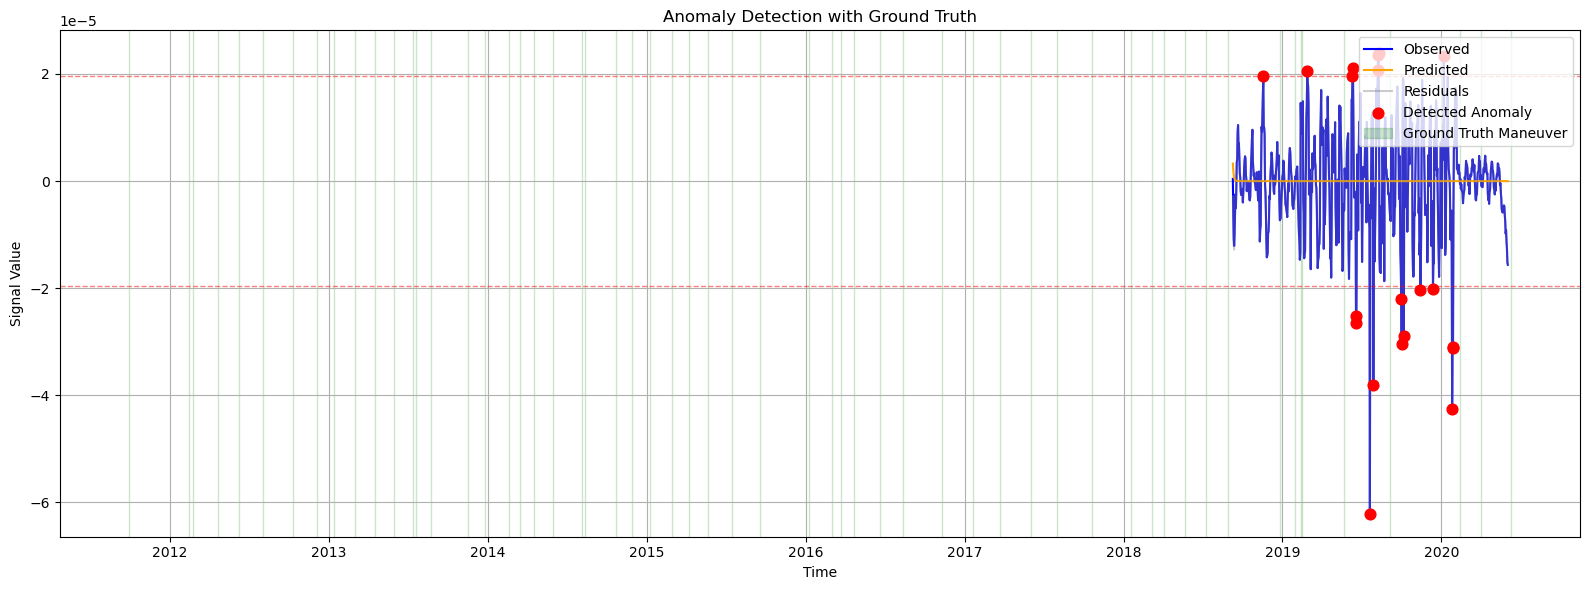

In [52]:
plot_all_in_one(test_data, test_predictions, residuals, threshold, man_df)

In [53]:
# Focused plot for particular dates 

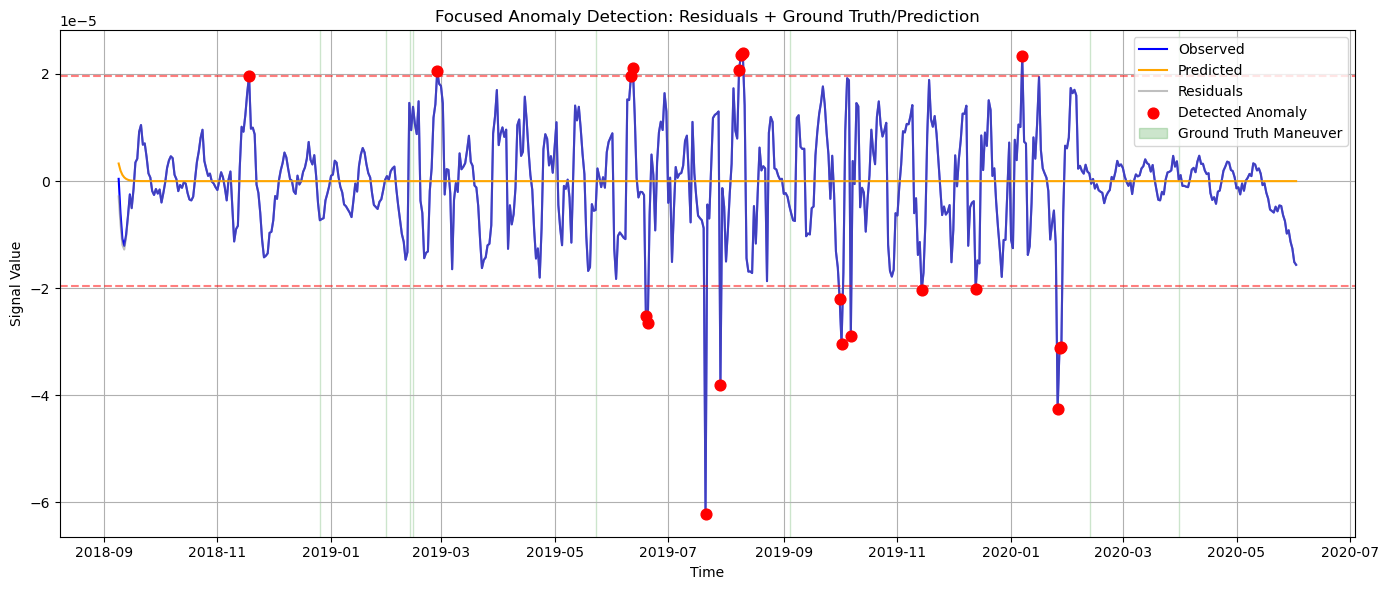

In [54]:
def plot_focused_anomalies(observed, predicted, residuals, threshold, man_df):
    
# Only keeping data where residuals exist to get foccused plot
    valid_times = residuals.dropna().index

# Find overlapping ground truth maneuvers for that points
    valid_man = man_df[
        (man_df['end_time'] >= valid_times.min()) &
        (man_df['start_time'] <= valid_times.max())
    ]

# Start and end time for plotting
    plot_start = max(valid_times.min(), predicted.dropna().index.min())
    plot_end = max(valid_times.max(), predicted.dropna().index.max())

# Filtering all data within the valid time range
    observed = observed[(observed.index >= plot_start) & (observed.index <= plot_end)]
    predicted = predicted[(predicted.index >= plot_start) & (predicted.index <= plot_end)]
    residuals = residuals[(residuals.index >= plot_start) & (residuals.index <= plot_end)]
    anomalies = detect_anomalies(residuals, threshold)
    anomalies = anomalies[(anomalies.index >= plot_start) & (anomalies.index <= plot_end)]

# Filtering maneuvers that intersect this range
    valid_man = valid_man[
        (valid_man['start_time'] <= plot_end) &
        (valid_man['end_time'] >= plot_start)
    ]

# Plot
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.plot(observed.index, observed.values, label='Observed', color='blue', linewidth=1.5)
    ax.plot(predicted.index, predicted.values, label='Predicted', color='orange', linewidth=1.5)
    ax.plot(residuals.index, residuals.values, color='grey', alpha=0.5, label='Residuals')

# Detected anomalies
    ax.scatter(anomalies.index, observed.loc[anomalies.index], color='red', s=60, label='Detected Anomaly', zorder=5)

# Residual threshold 
    ax.axhline(threshold, linestyle='--', color='red', alpha=0.5)
    ax.axhline(-threshold, linestyle='--', color='red', alpha=0.5)

# Ground truth
    for idx, row in valid_man.iterrows():
        ax.axvspan(row['start_time'], row['end_time'], color='green', alpha=0.2,
                   label='Ground Truth Maneuver' if idx == valid_man.index[0] else "")

    ax.set_title("Focused Anomaly Detection: Residuals + Ground Truth/Prediction")
    ax.set_xlabel("Time")
    ax.set_ylabel("Signal Value")
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_focused_anomalies(test_data, test_predictions, residuals, threshold, man_df)